# Run all the experiments for the MRMR paper

Performs all the experiments. 

In [1]:
import sys
sys.path.append("../..")
from exp_run_config import Config
Config.PROJECTNAME = "WaterBerryFarms"

import pathlib
from pprint import pprint
import gzip as compress
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

import wbf_figures
from wbf_simulate import run_nrobot1day

from information_model import StoredObservationIM

In [2]:
experiment = "mrmr"
lookup = {"mrmr-clustered-1pio-2con": "mrmr", "mrmr-clustered-3lawnmowers": "lawn", "mrmr-clustered-3random": "rwp", "mrmr-unclustered-1pio-2con" : "mrmr",
"mrmr-unclustered-3lawnmowers": "lawn", "mrmr-unclustered-3random": "rwp"}

In [3]:
# the experiment for this notebook
expall = Config().get_experiment(experiment, "mrmr_all")

for run in expall["allruns"]:
    exp = Config().get_experiment(experiment, run)
    pprint(exp)
    run_nrobot1day(exp)



***ExpRun**: Loading pointer config file:
	C:\Users\lboloni\.config\WaterBerryFarms\mainsettings.yaml
***ExpRun**: Loading machine-specific config file:
	G:\My Drive\LotziStudy\Code\PackageTracking\WaterBerryFarms\settings\WBF-config-LotziYoga.yaml
***ExpRun**: No system dependent experiment file
	 G:\My Drive\LotziStudy\Code\PackageTracking\WaterBerryFarms\settings\experiment-config\LotziYoga\mrmr\mrmr_all_sysdep.yaml,
	 that is ok, proceeding.
***ExpRun**: Configuration for exp/run: mrmr/mrmr_all successfully loaded
***ExpRun**: No system dependent experiment file
	 G:\My Drive\LotziStudy\Code\PackageTracking\WaterBerryFarms\settings\experiment-config\LotziYoga\mrmr\mrmr-clustered-1pio-2con_sysdep.yaml,
	 that is ok, proceeding.
***ExpRun**: Configuration for exp/run: mrmr/mrmr-clustered-1pio-2con successfully loaded
Experiment: {'velocity': 1, 'timesteps-per-day': 1000, 'time-start-environment': 25, 'im_resolution': 10, 'experiment_name': 'mrmr', 'name': '1 pioneer 2 contractors clu

In [4]:
# load back all the results 
all_results = {}

for run in expall["allruns"]:
    exp = Config().get_experiment(experiment, run)
    pprint(exp)

    resultsfile = pathlib.Path(exp["data_dir"], "results.pickle")
    if not resultsfile.exists():
        print(f"Results file does not exist:\n{resultsfile}")
        print("Run the notebook Run-1Robot1Day with the same exp/run to create it.")
        raise Exception("Nothing to do.")

    # load the results file
    with compress.open(resultsfile, "rb") as f:
        results = pickle.load(f)    
    all_results[run] = results


***ExpRun**: No system dependent experiment file
	 G:\My Drive\LotziStudy\Code\PackageTracking\WaterBerryFarms\settings\experiment-config\LotziYoga\mrmr\mrmr-clustered-1pio-2con_sysdep.yaml,
	 that is ok, proceeding.
***ExpRun**: Configuration for exp/run: mrmr/mrmr-clustered-1pio-2con successfully loaded
Experiment: {'velocity': 1, 'timesteps-per-day': 1000, 'time-start-environment': 25, 'im_resolution': 10, 'experiment_name': 'mrmr', 'name': '1 pioneer 2 contractors clustered', 'exp_environment': 'mrmr-custom-clustered', 'exp_estimator': 'adaptive-disk', 'exp_score': 'weighted_asymmetric', 'robots': [{'name': 'pio', 'exp-policy': 'generic', 'exp-policy-extra-parameters': {'policy-name': 'mrmr-pioneer', 'policy-code': 'MRMR_Pioneer', 'seed': 1, 'budget': 1000}}, {'name': 'con-1', 'exp-policy': 'generic', 'exp-policy-extra-parameters': {'policy-name': 'mrmr-contractor-1', 'policy-code': 'MRMR_Contractor', 'seed': 2, 'budget': 1000}}, {'name': 'con-2', 'exp-policy': 'generic', 'exp-poli

In [5]:
all_results.keys()

dict_keys(['mrmr-clustered-1pio-2con', 'mrmr-clustered-3lawnmowers', 'mrmr-clustered-3random', 'mrmr-unclustered-1pio-2con', 'mrmr-unclustered-3lawnmowers', 'mrmr-unclustered-3random'])

### Visualize the replanning process
* for all the mrmr scenarios, for the contractor agents
* for all the replanning points (which are the indexes of the oldplans dictionary)
* create a figure
* visualize the observations to that time with a continuous line
* visualize the rest of the plan from the oldplans

__FIXME__: There is some kind of problem about how the position of the robot is drawn. Somehow the robot position does not align with the end of the trajectory, no matter how I am taking the robot position from. May 8, 2025, I have turned this off, because it is more important to submit the paper, I will debug it later.

In [ ]:
def show_robot_with_plan(expall, scenario, results, robot, observations, oldplan, t):
    """Visualize the plan of the robot at a certain time point"""

    ROBOT_COLORS = ["#E69F00", "#56B4E9", "#009E73"]
    robot_color = ROBOT_COLORS[2]

    filename = f"plans_{scenario}_{robot.name}_{t}"

    fig, ax = plt.subplots(1,1, figsize=(3, 3))
    wbf_figures.show_env_tylcv(results, ax)
    # obs = observations[1:int(t)]
    # color = "blue"
    wbf_figures.show_individual_robot_path(results, ax, robot=robot, observations=observations, pathcolor=robot_color, pathwidth=1,  draw_robot=False, robotcolor=robot_color, from_obs=0, to_obs=int(t))

    # add the plan
    planx = [a["x"] for a in oldplan]
    plany = [a["y"] for a in oldplan]
    ax.add_line(matplotlib.lines.Line2D(planx, plany, color = robot_color, linestyle=":", linewidth=1))

    # position of the robot
    # ax.add_patch(matplotlib.patches.Circle((observations[int(t)]["x"], observations[int(t)]["y"]), radius=3, facecolor=robot_color))
    # ax.add_patch(matplotlib.patches.Circle((observations[-1]["x"], observations[-1]["y"]), radius=3, facecolor=robot_color))
    # ax.add_patch(matplotlib.patches.Circle((oldplan[0]["x"], oldplan[0]["y"]), radius=3, facecolor="yellow"))

    ax.set_title(f"{robot.name} at t={int(t)}")
    filepath = pathlib.Path(expall.data_dir(), f"{filename}.pdf")
    plt.savefig(filepath)
    print(f"Done saving to {filepath}")

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'MATH': 19 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'a', 'c', 'eight', 'equal', 'five', 'four', 'hyphen', 'n', 'nonmarkingreturn', 'o', 'one', 'seven', 'six', 'space', 't', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 19, 20, 21, 23, 24, 25, 26, 27, 32, 68, 70, 81, 82, 87]
INFO:fontTools.subset:Closed glyph list over 'MATH': 19 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'a', 'c', 'eight', 'equal', 'five', 'four', 'hyphen', 'n', 'nonmarkingreturn', 'o', 'one', 'seven', 'six', 'space', 't', 'two', 'ze

con-1
0.0


INFO:fontTools.subset:fpgm subsetting not needed
INFO:fontTools.subset:prep subsetting not needed
INFO:fontTools.subset:cvt  subsetting not needed
INFO:fontTools.subset:loca subsetting not needed
INFO:fontTools.subset:post subsetted
INFO:fontTools.subset:gasp subsetting not needed
INFO:fontTools.subset:MATH subsetted
INFO:fontTools.subset:GDEF subsetted
INFO:fontTools.subset:GPOS subsetted
INFO:fontTools.subset:GSUB subsetted
INFO:fontTools.subset:name subsetting not needed
INFO:fontTools.subset:glyf subsetted
INFO:fontTools.subset:head pruned
INFO:fontTools.subset:OS/2 Unicode ranges pruned: [0]
INFO:fontTools.subset:OS/2 CodePage ranges pruned: [0]
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:GDEF pruned
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped

Done saving to C:\Users\lboloni\Documents\Code\_TempData\WBF\ExperimentData\mrmr\mrmr_all\plans_mrmr-clustered-1pio-2con_con-1_0.0.pdf
211.0


INFO:fontTools.subset:prep subsetting not needed
INFO:fontTools.subset:cvt  subsetting not needed
INFO:fontTools.subset:loca subsetting not needed
INFO:fontTools.subset:post subsetted
INFO:fontTools.subset:gasp subsetting not needed
INFO:fontTools.subset:MATH subsetted
INFO:fontTools.subset:GDEF subsetted
INFO:fontTools.subset:GPOS subsetted
INFO:fontTools.subset:GSUB subsetted
INFO:fontTools.subset:name subsetting not needed
INFO:fontTools.subset:glyf subsetted
INFO:fontTools.subset:head pruned
INFO:fontTools.subset:OS/2 Unicode ranges pruned: [0]
INFO:fontTools.subset:OS/2 CodePage ranges pruned: [0]
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:GDEF pruned
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools

Done saving to C:\Users\lboloni\Documents\Code\_TempData\WBF\ExperimentData\mrmr\mrmr_all\plans_mrmr-clustered-1pio-2con_con-1_211.0.pdf
271.0


INFO:fontTools.subset:GPOS subsetted
INFO:fontTools.subset:GSUB subsetted
INFO:fontTools.subset:name subsetting not needed
INFO:fontTools.subset:glyf subsetted
INFO:fontTools.subset:head pruned
INFO:fontTools.subset:OS/2 Unicode ranges pruned: [0]
INFO:fontTools.subset:OS/2 CodePage ranges pruned: [0]
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:GDEF pruned
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'MATH': 20 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'a', 'c', 'eight', 'equal',

Done saving to C:\Users\lboloni\Documents\Code\_TempData\WBF\ExperimentData\mrmr\mrmr_all\plans_mrmr-clustered-1pio-2con_con-1_271.0.pdf
377.0


INFO:fontTools.subset:cvt  subsetting not needed
INFO:fontTools.subset:loca subsetting not needed
INFO:fontTools.subset:post subsetted
INFO:fontTools.subset:gasp subsetting not needed
INFO:fontTools.subset:MATH subsetted
INFO:fontTools.subset:GDEF subsetted
INFO:fontTools.subset:GPOS subsetted
INFO:fontTools.subset:GSUB subsetted
INFO:fontTools.subset:name subsetting not needed
INFO:fontTools.subset:glyf subsetted
INFO:fontTools.subset:head pruned
INFO:fontTools.subset:OS/2 Unicode ranges pruned: [0]
INFO:fontTools.subset:OS/2 CodePage ranges pruned: [0]
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:GDEF pruned
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pr

Done saving to C:\Users\lboloni\Documents\Code\_TempData\WBF\ExperimentData\mrmr\mrmr_all\plans_mrmr-clustered-1pio-2con_con-1_377.0.pdf
414.0


INFO:fontTools.subset:GSUB subsetted
INFO:fontTools.subset:name subsetting not needed
INFO:fontTools.subset:glyf subsetted
INFO:fontTools.subset:head pruned
INFO:fontTools.subset:OS/2 Unicode ranges pruned: [0]
INFO:fontTools.subset:OS/2 CodePage ranges pruned: [0]
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:GDEF pruned
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'MATH': 19 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'a', 'c', 'eight', 'equal', 'five', 'four', 'hyphen', 'n', 'nonm

Done saving to C:\Users\lboloni\Documents\Code\_TempData\WBF\ExperimentData\mrmr\mrmr_all\plans_mrmr-clustered-1pio-2con_con-1_414.0.pdf
con-2
0.0


INFO:fontTools.subset:cmap subsetted
INFO:fontTools.subset:fpgm subsetting not needed
INFO:fontTools.subset:prep subsetting not needed
INFO:fontTools.subset:cvt  subsetting not needed
INFO:fontTools.subset:loca subsetting not needed
INFO:fontTools.subset:post subsetted
INFO:fontTools.subset:gasp subsetting not needed
INFO:fontTools.subset:MATH subsetted
INFO:fontTools.subset:GDEF subsetted
INFO:fontTools.subset:GPOS subsetted
INFO:fontTools.subset:GSUB subsetted
INFO:fontTools.subset:name subsetting not needed
INFO:fontTools.subset:glyf subsetted
INFO:fontTools.subset:head pruned
INFO:fontTools.subset:OS/2 Unicode ranges pruned: [0]
INFO:fontTools.subset:OS/2 CodePage ranges pruned: [0]
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:GDEF pruned
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post prun

Done saving to C:\Users\lboloni\Documents\Code\_TempData\WBF\ExperimentData\mrmr\mrmr_all\plans_mrmr-clustered-1pio-2con_con-2_0.0.pdf
439.0


INFO:fontTools.subset:glyf subsetted
INFO:fontTools.subset:head pruned
INFO:fontTools.subset:OS/2 Unicode ranges pruned: [0]
INFO:fontTools.subset:OS/2 CodePage ranges pruned: [0]
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:GDEF pruned
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned


Done saving to C:\Users\lboloni\Documents\Code\_TempData\WBF\ExperimentData\mrmr\mrmr_all\plans_mrmr-clustered-1pio-2con_con-2_439.0.pdf
485.0


INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'MATH': 19 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'a', 'c', 'eight', 'equal', 'five', 'four', 'hyphen', 'n', 'nonmarkingreturn', 'o', 'one', 'seven', 'six', 'space', 't', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 19, 20, 21, 23, 24, 25, 26, 27, 32, 68, 70, 81, 82, 87]
INFO:fontTools.subset:Closed glyph list over 'MATH': 19 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'a', 'c', 'eight', 'equal', 'five', 'four', 'hyphen', 'n', 'nonmarkingreturn', 'o', 'one', 'seven', 'six', 'space', 't', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 19, 20, 21, 23, 24, 25, 26, 27, 32, 68, 70, 81, 82, 87]
INFO:fontTools.subset:Closing glyph list over 'GSUB': 19 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'a', 'c', 'eight', 'equal', 'five'

Done saving to C:\Users\lboloni\Documents\Code\_TempData\WBF\ExperimentData\mrmr\mrmr_all\plans_mrmr-clustered-1pio-2con_con-2_485.0.pdf
646.0


INFO:fontTools.subset:post subsetted
INFO:fontTools.subset:gasp subsetting not needed
INFO:fontTools.subset:MATH subsetted
INFO:fontTools.subset:GDEF subsetted
INFO:fontTools.subset:GPOS subsetted
INFO:fontTools.subset:GSUB subsetted
INFO:fontTools.subset:name subsetting not needed
INFO:fontTools.subset:glyf subsetted
INFO:fontTools.subset:head pruned
INFO:fontTools.subset:OS/2 Unicode ranges pruned: [0]
INFO:fontTools.subset:OS/2 CodePage ranges pruned: [0]
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:GDEF pruned
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to s

Done saving to C:\Users\lboloni\Documents\Code\_TempData\WBF\ExperimentData\mrmr\mrmr_all\plans_mrmr-clustered-1pio-2con_con-2_646.0.pdf
827.0


INFO:fontTools.subset:GPOS subsetted
INFO:fontTools.subset:GSUB subsetted
INFO:fontTools.subset:name subsetting not needed
INFO:fontTools.subset:glyf subsetted
INFO:fontTools.subset:head pruned
INFO:fontTools.subset:OS/2 Unicode ranges pruned: [0]
INFO:fontTools.subset:OS/2 CodePage ranges pruned: [0]
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:GDEF pruned
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'MATH': 19 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'a', 'c', 'eight', 'equal',

Done saving to C:\Users\lboloni\Documents\Code\_TempData\WBF\ExperimentData\mrmr\mrmr_all\plans_mrmr-clustered-1pio-2con_con-2_827.0.pdf
864.0


INFO:fontTools.subset:GPOS subsetted
INFO:fontTools.subset:GSUB subsetted
INFO:fontTools.subset:name subsetting not needed
INFO:fontTools.subset:glyf subsetted
INFO:fontTools.subset:head pruned
INFO:fontTools.subset:OS/2 Unicode ranges pruned: [0]
INFO:fontTools.subset:OS/2 CodePage ranges pruned: [0]
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:GDEF pruned
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'MATH': 19 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'a', 'c', 'eight', 'equal',

Done saving to C:\Users\lboloni\Documents\Code\_TempData\WBF\ExperimentData\mrmr\mrmr_all\plans_mrmr-clustered-1pio-2con_con-2_864.0.pdf
con-1
0.0


INFO:fontTools.subset:GSUB subsetted
INFO:fontTools.subset:name subsetting not needed
INFO:fontTools.subset:glyf subsetted
INFO:fontTools.subset:head pruned
INFO:fontTools.subset:OS/2 Unicode ranges pruned: [0]
INFO:fontTools.subset:OS/2 CodePage ranges pruned: [0]
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:GDEF pruned
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'MATH': 20 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'a', 'c', 'eight', 'equal', 'five', 'four', 'hyphen', 'n', 'nonm

Done saving to C:\Users\lboloni\Documents\Code\_TempData\WBF\ExperimentData\mrmr\mrmr_all\plans_mrmr-unclustered-1pio-2con_con-1_0.0.pdf
235.0


INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 19, 20, 21, 22, 23, 24, 25, 26, 27, 32, 68, 70, 81, 82, 87]
INFO:fontTools.subset:Closed glyph list over 'glyf': 20 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'a', 'c', 'eight', 'equal', 'five', 'four', 'hyphen', 'n', 'nonmarkingreturn', 'o', 'one', 'seven', 'six', 'space', 't', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 19, 20, 21, 22, 23, 24, 25, 26, 27, 32, 68, 70, 81, 82, 87]
INFO:fontTools.subset:Retaining 20 glyphs
INFO:fontTools.subset:head subsetting not needed
INFO:fontTools.subset:hhea subsetting not needed
INFO:fontTools.subset:maxp subsetting not needed
INFO:fontTools.subset:OS/2 subsetting not needed
INFO:fontTools.subset:hmtx subsetted
INFO:fontTools.subset:cmap subsetted
INFO:fontTools.subset:fpgm subsetting not needed
INFO:fontTools.subset:prep subsetting not needed
INFO:fontTools.subset:cvt  subsetting not needed
INFO:fontTools.subset:loca subsetting not neede

Done saving to C:\Users\lboloni\Documents\Code\_TempData\WBF\ExperimentData\mrmr\mrmr_all\plans_mrmr-unclustered-1pio-2con_con-1_235.0.pdf
266.0


INFO:fontTools.subset:GSUB subsetted
INFO:fontTools.subset:name subsetting not needed
INFO:fontTools.subset:glyf subsetted
INFO:fontTools.subset:head pruned
INFO:fontTools.subset:OS/2 Unicode ranges pruned: [0]
INFO:fontTools.subset:OS/2 CodePage ranges pruned: [0]
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:GDEF pruned
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'MATH': 20 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'a', 'c', 'eight', 'equal', 'five', 'four', 'hyphen', 'n', 'nonm

Done saving to C:\Users\lboloni\Documents\Code\_TempData\WBF\ExperimentData\mrmr\mrmr_all\plans_mrmr-unclustered-1pio-2con_con-1_266.0.pdf
273.0


INFO:fontTools.subset:fpgm subsetting not needed
INFO:fontTools.subset:prep subsetting not needed
INFO:fontTools.subset:cvt  subsetting not needed
INFO:fontTools.subset:loca subsetting not needed
INFO:fontTools.subset:post subsetted
INFO:fontTools.subset:gasp subsetting not needed
INFO:fontTools.subset:MATH subsetted
INFO:fontTools.subset:GDEF subsetted
INFO:fontTools.subset:GPOS subsetted
INFO:fontTools.subset:GSUB subsetted
INFO:fontTools.subset:name subsetting not needed
INFO:fontTools.subset:glyf subsetted
INFO:fontTools.subset:head pruned
INFO:fontTools.subset:OS/2 Unicode ranges pruned: [0]
INFO:fontTools.subset:OS/2 CodePage ranges pruned: [0]
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:GDEF pruned
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped

Done saving to C:\Users\lboloni\Documents\Code\_TempData\WBF\ExperimentData\mrmr\mrmr_all\plans_mrmr-unclustered-1pio-2con_con-1_273.0.pdf
362.0


INFO:fontTools.subset:GPOS subsetted
INFO:fontTools.subset:GSUB subsetted
INFO:fontTools.subset:name subsetting not needed
INFO:fontTools.subset:glyf subsetted
INFO:fontTools.subset:head pruned
INFO:fontTools.subset:OS/2 Unicode ranges pruned: [0]
INFO:fontTools.subset:OS/2 CodePage ranges pruned: [0]
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:GDEF pruned
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'MATH': 20 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'a', 'c', 'eight', 'equal',

Done saving to C:\Users\lboloni\Documents\Code\_TempData\WBF\ExperimentData\mrmr\mrmr_all\plans_mrmr-unclustered-1pio-2con_con-1_362.0.pdf
385.0


INFO:fontTools.subset:maxp subsetting not needed
INFO:fontTools.subset:OS/2 subsetting not needed
INFO:fontTools.subset:hmtx subsetted
INFO:fontTools.subset:cmap subsetted
INFO:fontTools.subset:fpgm subsetting not needed
INFO:fontTools.subset:prep subsetting not needed
INFO:fontTools.subset:cvt  subsetting not needed
INFO:fontTools.subset:loca subsetting not needed
INFO:fontTools.subset:post subsetted
INFO:fontTools.subset:gasp subsetting not needed
INFO:fontTools.subset:MATH subsetted
INFO:fontTools.subset:GDEF subsetted
INFO:fontTools.subset:GPOS subsetted
INFO:fontTools.subset:GSUB subsetted
INFO:fontTools.subset:name subsetting not needed
INFO:fontTools.subset:glyf subsetted
INFO:fontTools.subset:head pruned
INFO:fontTools.subset:OS/2 Unicode ranges pruned: [0]
INFO:fontTools.subset:OS/2 CodePage ranges pruned: [0]
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:GDEF pruned
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned

Done saving to C:\Users\lboloni\Documents\Code\_TempData\WBF\ExperimentData\mrmr\mrmr_all\plans_mrmr-unclustered-1pio-2con_con-1_385.0.pdf
439.0


INFO:fontTools.subset:GPOS subsetted
INFO:fontTools.subset:GSUB subsetted
INFO:fontTools.subset:name subsetting not needed
INFO:fontTools.subset:glyf subsetted
INFO:fontTools.subset:head pruned
INFO:fontTools.subset:OS/2 Unicode ranges pruned: [0]
INFO:fontTools.subset:OS/2 CodePage ranges pruned: [0]
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:GDEF pruned
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned


Done saving to C:\Users\lboloni\Documents\Code\_TempData\WBF\ExperimentData\mrmr\mrmr_all\plans_mrmr-unclustered-1pio-2con_con-1_439.0.pdf
549.0


INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'MATH': 20 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'a', 'c', 'eight', 'equal', 'five', 'four', 'hyphen', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'seven', 'six', 'space', 't', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 19, 20, 21, 23, 24, 25, 26, 27, 28, 32, 68, 70, 81, 82, 87]
INFO:fontTools.subset:Closed glyph list over 'MATH': 20 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'a', 'c', 'eight', 'equal', 'five', 'four', 'hyphen', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'seven', 'six', 'space', 't', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 19, 20, 21, 23, 24, 25, 26, 27, 28, 32, 68, 70, 81, 82, 87]
INFO:fontTools.subset:Closing glyph list over 'GSUB': 20 glyphs before
INFO:fontTools.subset:Glyph name

Done saving to C:\Users\lboloni\Documents\Code\_TempData\WBF\ExperimentData\mrmr\mrmr_all\plans_mrmr-unclustered-1pio-2con_con-1_549.0.pdf
595.0


INFO:fontTools.subset:fpgm subsetting not needed
INFO:fontTools.subset:prep subsetting not needed
INFO:fontTools.subset:cvt  subsetting not needed
INFO:fontTools.subset:loca subsetting not needed
INFO:fontTools.subset:post subsetted
INFO:fontTools.subset:gasp subsetting not needed
INFO:fontTools.subset:MATH subsetted
INFO:fontTools.subset:GDEF subsetted
INFO:fontTools.subset:GPOS subsetted
INFO:fontTools.subset:GSUB subsetted
INFO:fontTools.subset:name subsetting not needed
INFO:fontTools.subset:glyf subsetted
INFO:fontTools.subset:head pruned
INFO:fontTools.subset:OS/2 Unicode ranges pruned: [0]
INFO:fontTools.subset:OS/2 CodePage ranges pruned: [0]
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:GDEF pruned
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
C:\Users\lboloni\AppData\Local\Temp\ipykernel_47648\1934634671.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`

Done saving to C:\Users\lboloni\Documents\Code\_TempData\WBF\ExperimentData\mrmr\mrmr_all\plans_mrmr-unclustered-1pio-2con_con-1_595.0.pdf
768.0


INFO:fontTools.subset:GSUB subsetted
INFO:fontTools.subset:name subsetting not needed
INFO:fontTools.subset:glyf subsetted
INFO:fontTools.subset:head pruned
INFO:fontTools.subset:OS/2 Unicode ranges pruned: [0]
INFO:fontTools.subset:OS/2 CodePage ranges pruned: [0]
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:GDEF pruned
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'MATH': 19 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'a', 'c', 'eight', 'equal', 'five', 'four', 'hyphen', 'n', 'nonm

Done saving to C:\Users\lboloni\Documents\Code\_TempData\WBF\ExperimentData\mrmr\mrmr_all\plans_mrmr-unclustered-1pio-2con_con-1_768.0.pdf
con-2
0.0


INFO:fontTools.subset:Closing glyph list over 'glyf': 19 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'a', 'c', 'eight', 'equal', 'five', 'four', 'hyphen', 'n', 'nonmarkingreturn', 'o', 'one', 'seven', 'six', 'space', 't', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 19, 20, 21, 23, 24, 25, 26, 27, 32, 68, 70, 81, 82, 87]
INFO:fontTools.subset:Closed glyph list over 'glyf': 19 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'a', 'c', 'eight', 'equal', 'five', 'four', 'hyphen', 'n', 'nonmarkingreturn', 'o', 'one', 'seven', 'six', 'space', 't', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 19, 20, 21, 23, 24, 25, 26, 27, 32, 68, 70, 81, 82, 87]
INFO:fontTools.subset:Retaining 19 glyphs
INFO:fontTools.subset:head subsetting not needed
INFO:fontTools.subset:hhea subsetting not needed
INFO:fontTools.subset:maxp subsetting not needed
INFO:fontTools.subset:OS/2 subsetting not needed
INFO:fontTools.subset:

Done saving to C:\Users\lboloni\Documents\Code\_TempData\WBF\ExperimentData\mrmr\mrmr_all\plans_mrmr-unclustered-1pio-2con_con-2_0.0.pdf
802.0


INFO:fontTools.subset:GSUB subsetted
INFO:fontTools.subset:name subsetting not needed
INFO:fontTools.subset:glyf subsetted
INFO:fontTools.subset:head pruned
INFO:fontTools.subset:OS/2 Unicode ranges pruned: [0]
INFO:fontTools.subset:OS/2 CodePage ranges pruned: [0]
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:GDEF pruned
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'MATH': 20 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'a', 'c', 'eight', 'equal', 'five', 'four', 'hyphen', 'n', 'nine

Done saving to C:\Users\lboloni\Documents\Code\_TempData\WBF\ExperimentData\mrmr\mrmr_all\plans_mrmr-unclustered-1pio-2con_con-2_802.0.pdf
829.0


INFO:fontTools.subset:fpgm subsetting not needed
INFO:fontTools.subset:prep subsetting not needed
INFO:fontTools.subset:cvt  subsetting not needed
INFO:fontTools.subset:loca subsetting not needed
INFO:fontTools.subset:post subsetted
INFO:fontTools.subset:gasp subsetting not needed
INFO:fontTools.subset:MATH subsetted
INFO:fontTools.subset:GDEF subsetted
INFO:fontTools.subset:GPOS subsetted
INFO:fontTools.subset:GSUB subsetted
INFO:fontTools.subset:name subsetting not needed
INFO:fontTools.subset:glyf subsetted
INFO:fontTools.subset:head pruned
INFO:fontTools.subset:OS/2 Unicode ranges pruned: [0]
INFO:fontTools.subset:OS/2 CodePage ranges pruned: [0]
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:GDEF pruned
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped

Done saving to C:\Users\lboloni\Documents\Code\_TempData\WBF\ExperimentData\mrmr\mrmr_all\plans_mrmr-unclustered-1pio-2con_con-2_829.0.pdf
859.0


INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'MATH': 20 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'a', 'c', 'eight', 'equal', 'five', 'four', 'hyphen', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'seven', 'six', 'space', 't', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 19, 20, 21, 23, 24, 25, 26, 27, 28, 32, 68, 70, 81, 82, 87]
INFO:fontTools.subset:Closed glyph list over 'MATH': 20 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'a', 'c', 'eight', 'equal', 'five', 'four', 'hyphen', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'seven', 'six', 'space', 't', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 19, 20, 21, 23, 24, 25, 26, 27, 28, 32, 68, 70, 81, 82, 87]
INFO:fontTools.subset:Closing glyph list over 'GSUB': 20 glyphs before
INFO:fontTools.subset:Glyph name

Done saving to C:\Users\lboloni\Documents\Code\_TempData\WBF\ExperimentData\mrmr\mrmr_all\plans_mrmr-unclustered-1pio-2con_con-2_859.0.pdf


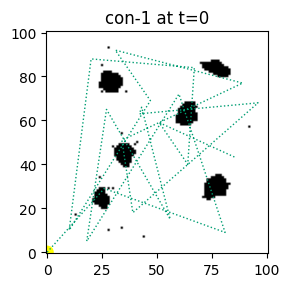

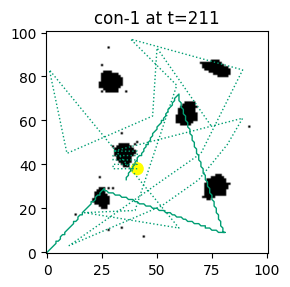

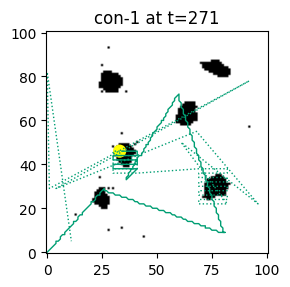

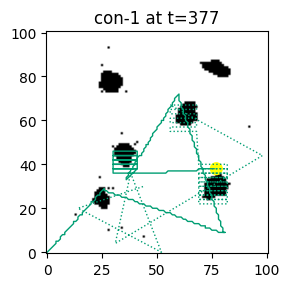

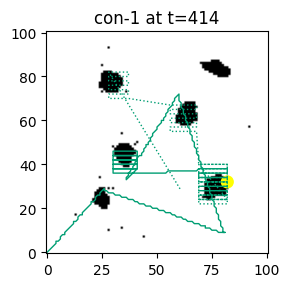

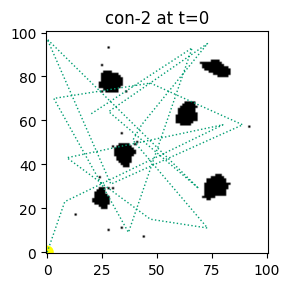

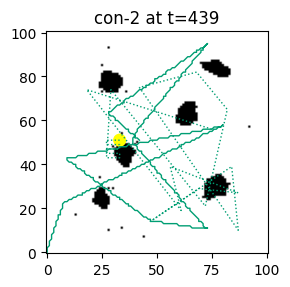

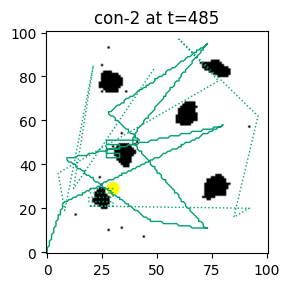

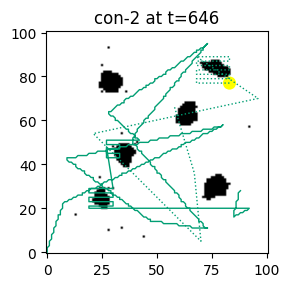

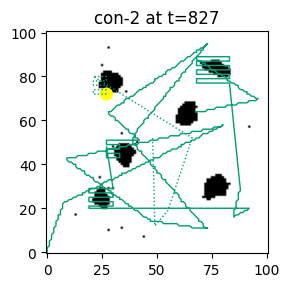

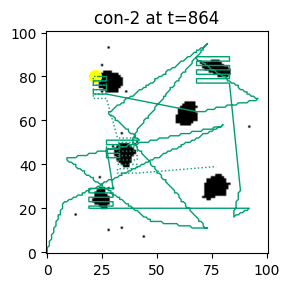

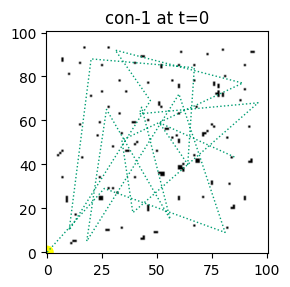

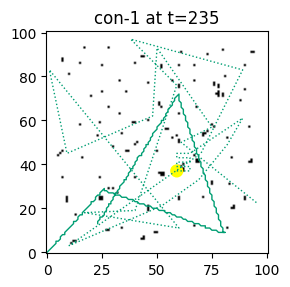

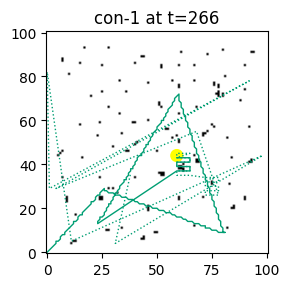

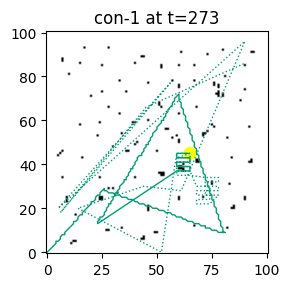

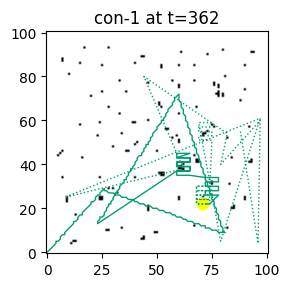

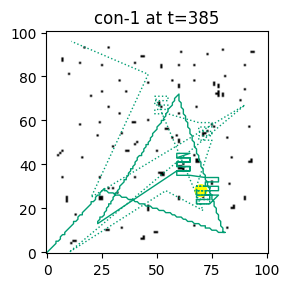

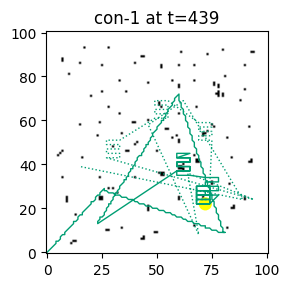

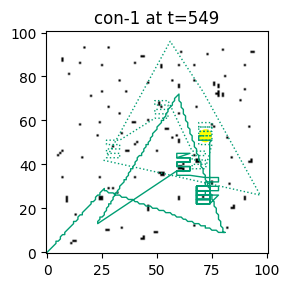

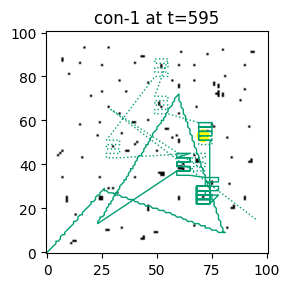

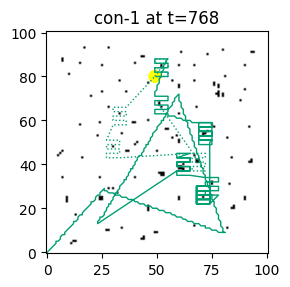

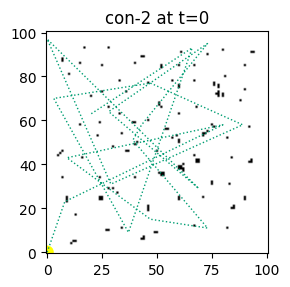

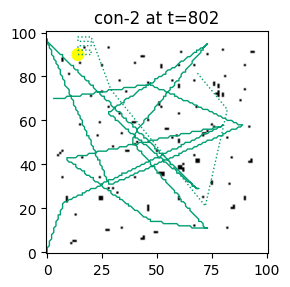

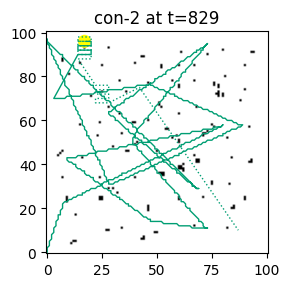

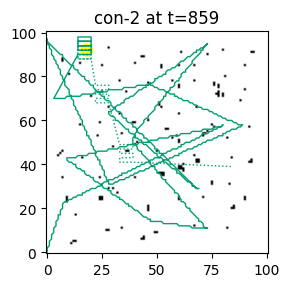

In [16]:
for scenario in all_results:
    if "1pio" not in scenario: continue
    results = all_results[scenario]
    for i, robot in enumerate(results["robots"]):
        if "con" in robot.name:
            print(robot.name)
            # FIXME: I think that the problem here is that I won't have access to the policy here, so I will need to store the old plans somewhere else... maybe in the robot...?
            observations = [o[i] for o in results["observations"]]
            oldplans = robot.oldplans
            for t in oldplans:
                print(t)
                oldplan = oldplans[t]
                show_robot_with_plan(expall, scenario, results, robot, observations, oldplan, t)

### Visualize detection paths 
* for all running scenarios
* create a graph for the visualization of the paths, with the visualize the detections
* create a bargraph with the number of detection points for each of them
* FIXME: maybe also visualize the money for the mrmr agents

In [8]:
def show_robot_trajectories_and_detections(expall, name, results, robot_colors):

    fig, ax = plt.subplots(1,1, figsize=(3, 3))
    wbf_figures.show_env_tylcv(results, ax)
    ax.set_title(lookup[name])
    custom_lines = []
    labels = []

    for i, robot in enumerate(results["robots"]):
        color = robot_colors[i % len(results["robots"])]
        observations = [o[i] for o in results["observations"]]
        wbf_figures.show_individual_robot_path(results, ax, robot=robot, observations=observations, pathcolor=color, draw_robot=False)
        wbf_figures.show_individual_robot_detections(results, ax, robotno=i, detection_color=color, radius=0.5)
        # adding to the legend
        custom_lines.append(matplotlib.lines.Line2D([0], [0], color=color, lw=2))
        labels.append(robot.name)


    # Add both automatic and manual entries to the legend
    ax.legend(handles=[*custom_lines],
            labels=labels)    

    plt.savefig(pathlib.Path(expall.data_dir(), f"detections-map-{name}.pdf"))

In [9]:
def count_detections(results, robotno, field = "TYLCV"):
    """Returns the number of detections for the specified robot, adapted from wbf_figures.show_detections"""
    obs = np.array(results["observations"])[:, robotno]
    detections = [[a[StoredObservationIM.X], a[StoredObservationIM.Y]] for a in obs if a[field][StoredObservationIM.VALUE] == 0.0]
    return len(detections)

In [10]:
def show_agentwise_detections(expall, name, results, robot_colors):    
    fig, ax = plt.subplots(1,1, figsize=(3, 3))
    ax.set_title(lookup[name])
    total = 0
    for i, robot in enumerate(results["robots"]):
        detections = count_detections(results, i)
        total += detections
        br = ax.bar(robot.name, detections, color=robot_colors[i])
    ax.bar("Total", total, color="gray")
    plt.savefig(pathlib.Path(expall.data_dir(), f"detections-bar-{name}.pdf"))

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'MATH': 20 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'c', 'eight', 'five', 'four', 'hyphen', 'i', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 'seven', 'six', 'space', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 19, 20, 21, 23, 24, 25, 26, 27, 70, 76, 80, 81, 82, 83, 85]
INFO:fontTools.subset:Closed glyph list over 'MATH': 20 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'c', 'eight', 'five', 'four', 'hyphen', 'i', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 'seven', 'six', 'space', 'two

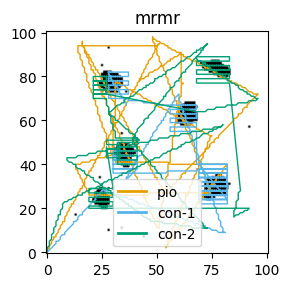

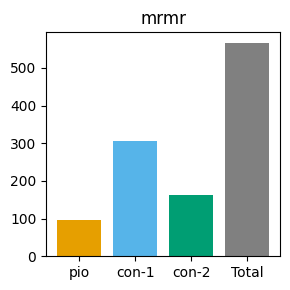

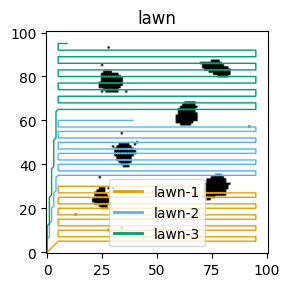

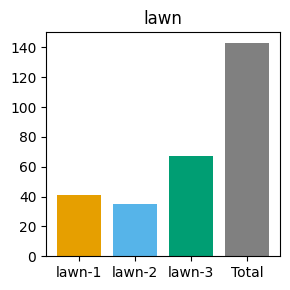

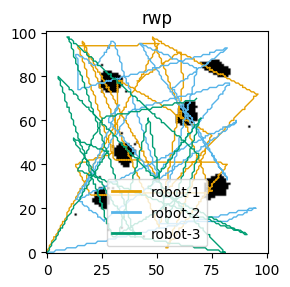

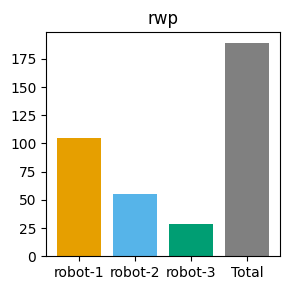

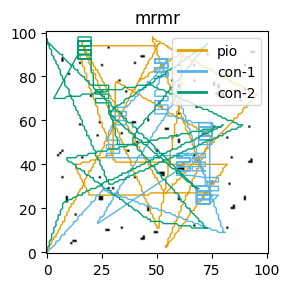

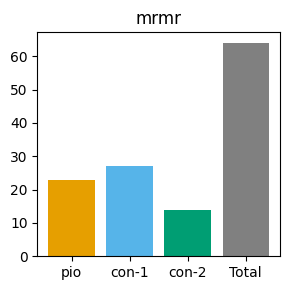

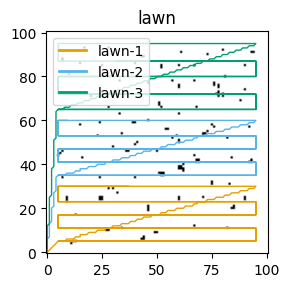

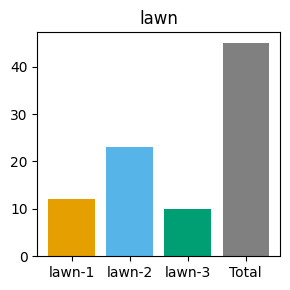

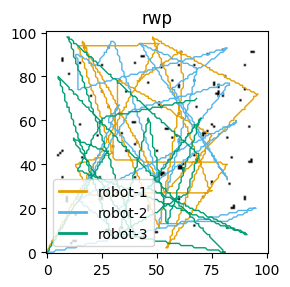

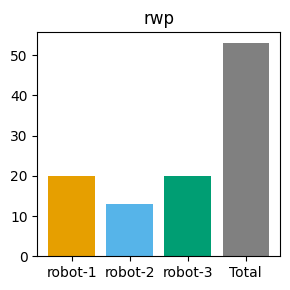

In [11]:
#ROBOT_COLORS = ["red", "blue", "green"]
ROBOT_COLORS = ["#E69F00", "#56B4E9", "#009E73"]
for scenario in all_results:
    results = all_results[scenario]
    name = scenario
    show_robot_trajectories_and_detections(expall, name, results, robot_colors=ROBOT_COLORS)    
    show_agentwise_detections(expall, name, results, robot_colors = ROBOT_COLORS)

### Overall pickings comparison graphs 
* compare the unclustered and clustered cases 
* create comparison graphs

In [12]:
name_colors = ["#CC6666", "#9999CC", "#66CC99"]

In [13]:
def show_comparative_detections(expall, name, values):    
    fig, ax = plt.subplots(1,1, figsize=(3, 3))
    for i, policyname in enumerate(values):
        br = ax.bar(lookup[policyname], values[policyname], color=name_colors[i])
    plt.savefig(pathlib.Path(expall.data_dir(), f"comparative-bar-{name}.pdf"))

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'MATH': 17 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'a', 'five', 'four', 'l', 'm', 'n', 'nonmarkingreturn', 'one', 'p', 'r', 'space', 'three', 'two', 'w', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 68, 79, 80, 81, 83, 85, 90]
INFO:fontTools.subset:Closed glyph list over 'MATH': 17 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'a', 'five', 'four', 'l', 'm', 'n', 'nonmarkingreturn', 'one', 'p', 'r', 'space', 'three', 'two', 'w', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 2

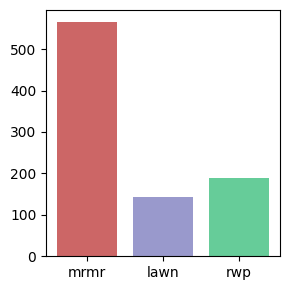

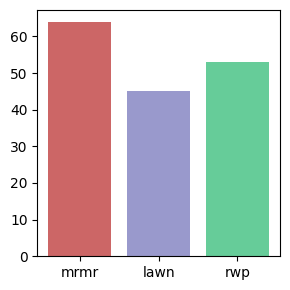

In [14]:
for group in ["clustered-runs", "unclustered-runs"]:
    values = {}
    for scenario in expall[group]:
        results = all_results[scenario]
        total = 0
        for i, robot in enumerate(results["robots"]):
            detections = count_detections(results, i)
            total += detections
        values[scenario] = total
    show_comparative_detections(expall, f"comparative-{group}", values)